# Research Project Experiment

In [1]:
# import
import torch.nn as nn
import torch
import snntorch as snn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# dataloader arguments
batch_size = 128 
data_path='./data/mnist'

dtype = torch.float
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
## if you're on M1 or M2 GPU:
device = torch.device("mps")

In [3]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.KMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.KMNIST(data_path, train=False, download=True, transform=transform)
# datasets.

In [4]:
# Create DataLoaders
# train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# Network Architecture
num_inputs = 28*28
# num_hidden = 500 # vary
num_outputs = 10

# Temporal Dynamics
# num_steps = 25 # vary
# beta = 0.95 # vary 

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self, num_hidden, new_beta, num_steps):
    # def __init__(self):

        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=new_beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=new_beta)
        self.num_steps = num_steps

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
# net = Net(500, 0.95).to(device)

In [7]:
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# num_epochs = 1
# loss_hist = []
# test_loss_hist = []
# counter = 0

# # Outer training loop
# for epoch in range(num_epochs):
#     train_batch = iter(train_loader)

#     # Minibatch training loop
#     for data, targets in train_batch:
#         data = data.to(device)
#         targets = targets.to(device)

#         # forward pass
#         net.train()
#         spk_rec, _ = net(data.flatten(1))

#         # initialize the loss & sum over time
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         loss_val += loss(spk_rec.sum(0), targets)

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         # Print train/test loss/accuracy
#         if counter % 10 == 0:
#             print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
#         counter += 1

#         if counter == 50:
#           break

In [8]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data.flatten(1))
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct
    
    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [9]:
# print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")

In [10]:
cummulate_loss_history = []

def calc_fitness(batch_size, num_hidden, beta, num_steps):
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

    net = Net(num_hidden, beta, num_steps).to(device)
    loss = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

    num_epochs = 1
    loss_hist = []
    test_loss_hist = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, _ = net(data.flatten(1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            loss_val += loss(spk_rec.sum(0), targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # Print train/test loss/accuracy
            # if counter % 10 == 0:
            #     print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
            counter += 1

            # if counter == 50:
            #     break
    
    cummulate_loss_history.append(loss_hist)
    return measure_accuracy(net, test_loader)

In [14]:
# CS 420/CS 527 Lab 2: Genetic Algorithms in LEAP 
# Author: Catherine Schuman
# February 2022

evaluation_log = []  # Global list to store rows for dataframe
current_gen = 0

import os
import numpy as np
from toolz import pipe

from leap_ec import Individual, context, test_env_var
from leap_ec import ops, probe, util
from leap_ec.decoder import IdentityDecoder
from leap_ec.binary_rep.problems import MaxOnes
from leap_ec.binary_rep.initializers import create_binary_sequence
from leap_ec.binary_rep.ops import mutate_bitflip
from leap_ec.binary_rep.problems import ScalarProblem
import argparse
import sys

# Implementation of a custom problem
class Lab2Problem(ScalarProblem):
    def __init__(self):
        super().__init__(maximize=True)
        
    def evaluate(self, ind):
        
        binary_str = ''.join(['1' if b else '0' for b in ind])

        # Bit slices
        batch_bits   = int(binary_str[0:3], 2)    # 3 bits = 0–7
        hidden_bits  = int(binary_str[3:9], 2)    # 6 bits = 0–63
        beta_bits    = int(binary_str[9:14], 2)   # 5 bits = 0–31
        steps_bits   = int(binary_str[14:17], 2)  # 3 bits = 0–7

        # Map to real hyperparameters
        batch_size  = 64 + (batch_bits % 7) * 32         # 64, 96, ..., 256
        num_hidden = 200 + (hidden_bits % 41) * 20      # 200–1000
        beta        = round(0.5 + (beta_bits / 31) * (0.99 - 0.5), 4)  # 0.5–0.99
        num_steps   = 10 + (steps_bits % 5) * 10

        accuracy = calc_fitness(batch_size=batch_size, num_hidden=num_hidden, beta=beta, num_steps=num_steps)

        evaluation_log.append({
            # "generation": context.generation,
            "generation": current_gen,
            "batch_size": batch_size,
            "num_hidden": num_hidden,
            "beta": beta,
            "num_steps": num_steps,
            "accuracy": accuracy
        })

        # return calc_fitness()
        return accuracy


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="Lab 2: Genetic Algorithms")
#     parser.add_argument("--n", default=50, help="population size", type=int)
#     parser.add_argument("--p_m", default=0.01, help="probability of mutation", type=float)
#     parser.add_argument("--p_c", default=0.3, help="probability of crossover", type=float)
#     parser.add_argument("--trn_size", default=2, help="tournament size", type=int)
#     parser.add_argument("--csv_output", required=True, help="csv output file name", type=str)
#     args = parser.parse_args()    

N = 10
p_m = 0.01
p_c = 0.3
trn_size = 3

max_generation = 15
l = 17
parents = Individual.create_population(N,
                                       initialize=create_binary_sequence(
                                           l),
                                       decoder=IdentityDecoder(),
                                       problem=Lab2Problem())

# Evaluate initial population
parents = Individual.evaluate_population(parents)

generation_counter = util.inc_generation()
out_f = open("best.txt", "w")

while generation_counter.generation() < max_generation:
    print(current_gen)
    offspring = pipe(parents,
                     ops.tournament_selection(k=trn_size),
                     ops.clone,
                     mutate_bitflip(probability=p_m),
                     ops.UniformCrossover(p_xover=p_c),
                     ops.evaluate,
                     ops.pool(size=len(parents)),  # accumulate offspring
                     probe.AttributesCSVProbe(stream=out_f, do_fitness=True)
                    )
    
    parents = offspring
    generation_counter()  # increment to the next generation
    current_gen += 1

out_f.close()
df = pd.DataFrame(evaluation_log)
df.to_csv("evolution_log.csv", index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [16]:
import pandas as pd

df = pd.DataFrame(cummulate_loss_history)
df.to_csv("cummulate_loss_history.csv", index=False)

In [17]:
import json

with open("cummulate_loss_history_JSON.json", "w") as f:
    json.dump(cummulate_loss_history, f)

In [4]:
import json
with open("cummulate_loss_history_JSON.json", "r") as f:
    history = json.load(f)

In [5]:
# np.array_equal(cummulate_loss_history, history)
cummulate_loss_history == history

NameError: name 'cummulate_loss_history' is not defined

In [ ]:
# df_list = pd.read_csv("cummulate_loss_history.csv")
# history2 = df_list.values.tolist()

In [ ]:
# np.array_equal(cummulate_loss_history, history2)

False

In [ ]:
# history2 == history

False

In [13]:
# # plot best accuracy per generation
# best_by_gen = df.groupby("generation")["accuracy"].mean()
# plt.plot(best_by_gen.index, best_by_gen.values)
# plt.xlabel("Generation")
# plt.ylabel("Best Accuracy (%)")
# plt.title("Evolution Progress")
# plt.grid(True)
# plt.show()

df = pd.read_csv("evolution_log.csv")
def plot_param_vs_accuracy(param_name, fixed_values):
    """
    param_name: string, name of the param to vary on x-axis
    fixed_values: dict, key=param to fix, value=fixed value
    """
    # Filter df to only rows matching fixed values
    filtered_df = df.copy()
    for key, value in fixed_values.items():
        filtered_df = filtered_df[filtered_df[key] == value]

    # Group by the variable of interest and average accuracy
    grouped = filtered_df.groupby(param_name)["accuracy"].mean()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped.values, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("Average Accuracy (%)")
    plt.title(f"{param_name} vs Accuracy (others fixed)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

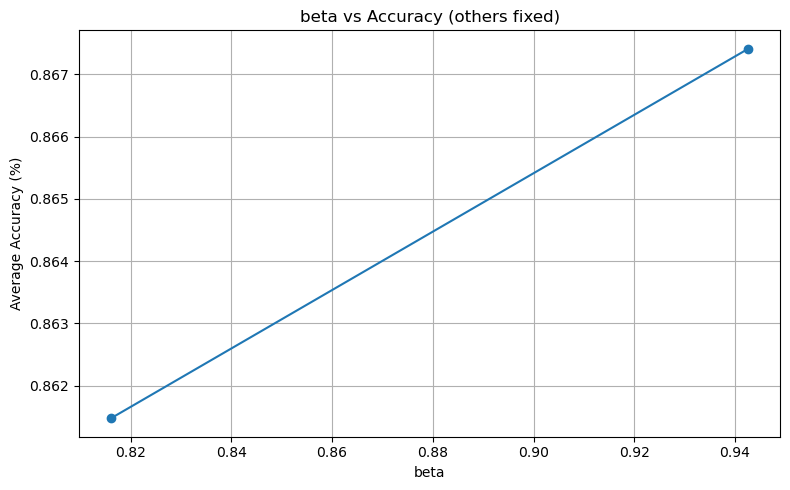

In [16]:
# Plot beta vs accuracy, keeping others constant
plot_param_vs_accuracy(
    param_name="beta",
    fixed_values={"batch_size": 128, "num_hidden": 880, "num_steps": 20}
)

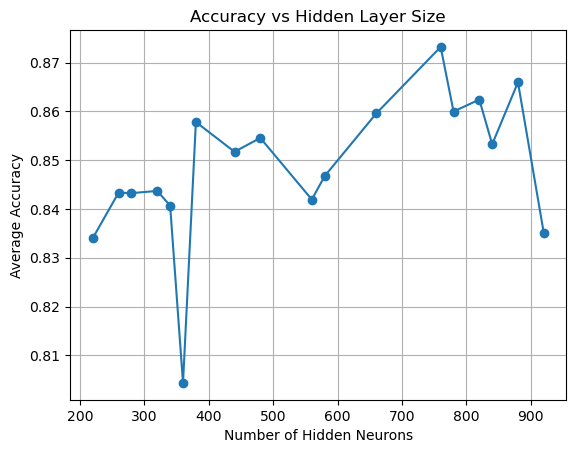

In [18]:
grouped = df.groupby("num_hidden")["accuracy"].mean()

# Option 1: Convert to dictionary
group_dict = grouped.to_dict()

# Option 2: Get x and y lists for plotting
x = grouped.index.tolist()   # This will be your 'num_hidden' values
y = grouped.values.tolist()  # This will be the average accuracies

# Now you can plot:
plt.plot(x, y, marker='o')
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Hidden Layer Size")
plt.grid(True)
plt.show()

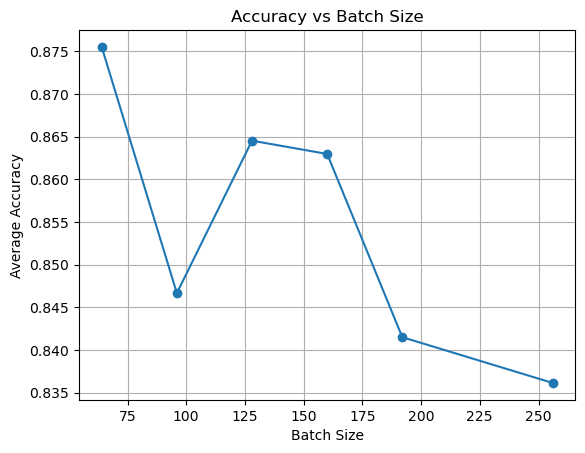

In [19]:
grouped = df.groupby("batch_size")["accuracy"].mean()

# Option 1: Convert to dictionary
group_dict = grouped.to_dict()

# Option 2: Get x and y lists for plotting
x = grouped.index.tolist()   # This will be your 'num_hidden' values
y = grouped.values.tolist()  # This will be the average accuracies

# Now you can plot:
plt.plot(x, y, marker='o')
plt.xlabel("Batch Size")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Batch Size")
plt.grid(True)
plt.show()

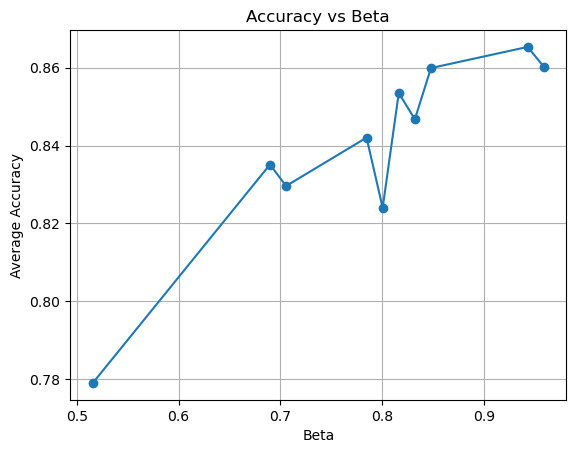

In [20]:
grouped = df.groupby("beta")["accuracy"].mean()

# Option 1: Convert to dictionary
group_dict = grouped.to_dict()

# Option 2: Get x and y lists for plotting
x = grouped.index.tolist()   # This will be your 'num_hidden' values
y = grouped.values.tolist()  # This will be the average accuracies

# Now you can plot:
plt.plot(x, y, marker='o')
plt.xlabel("Beta")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Beta")
plt.grid(True)
plt.show()

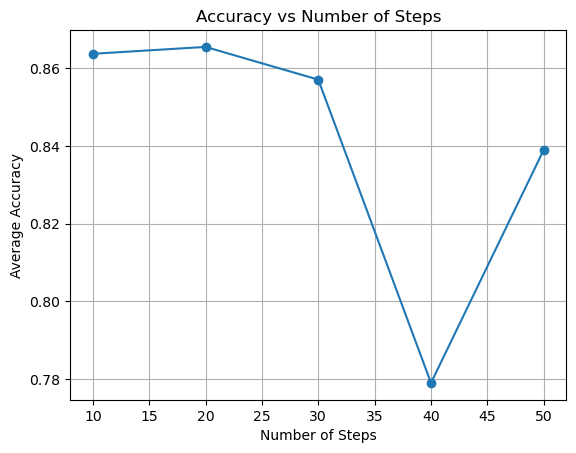

In [21]:
grouped = df.groupby("num_steps")["accuracy"].mean()

# Option 1: Convert to dictionary
group_dict = grouped.to_dict()

# Option 2: Get x and y lists for plotting
x = grouped.index.tolist()   # This will be your 'num_hidden' values
y = grouped.values.tolist()  # This will be the average accuracies

# Now you can plot:
plt.plot(x, y, marker='o')
plt.xlabel("Number of Steps")
plt.ylabel("Average Accuracy")
plt.title("Accuracy vs Number of Steps")
plt.grid(True)
plt.show()

In [7]:
df["accuracy"].max()

0.8836137652397156

In [34]:
# Call fitness function for both models (when training logic is finished inside it)
baseline_acc = calc_fitness(
    batch_size=128,
    num_hidden=1000,
    beta=0.95,
    num_steps=25
)

# evolved_acc = calc_fitness(
#     batch_size=128,
#     num_hidden=650,  # example evolved values
#     beta=0.90,
#     num_steps=30
# )

In [35]:
baseline_acc

0.8539663553237915

In [ ]:
plt.bar(["Baseline", "Evolved"], [baseline_acc * 100, evolved_acc * 100])
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Accuracy")
plt.ylim(0, 100)
plt.show()

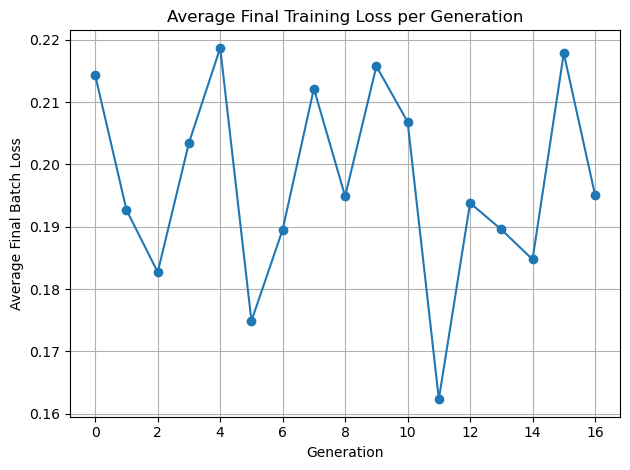

In [12]:
# plt.figure(figsize=(10, 6))

# for i, loss_list in enumerate(history):
#     plt.plot(loss_list, label=f"Run {i+1}", alpha=0.4)

# plt.title("Training Loss per Batch (Each Model Run)")
# plt.xlabel("Batch Step")
# plt.ylabel("Loss")
# plt.legend(loc="upper right", fontsize='small', ncol=2)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# loss_auc = [sum(run) for run in history]
# plt.plot(loss_auc, marker='o')
# plt.title("Total Training Loss (AUC) per Model Run")
# plt.xlabel("Run Index")
# plt.ylabel("Total Loss")
# plt.grid(True)
# plt.show()
N = 10  # individuals per generation
num_generations = len(history) // N

final_losses = [run[-1] for run in history]

# Group final losses into generations
final_loss_per_gen = [
    final_losses[i * N: (i + 1) * N]
    for i in range(num_generations)
]

# Average final loss per generation
avg_final_loss_per_gen = [sum(gen_losses)/len(gen_losses) for gen_losses in final_loss_per_gen]

import matplotlib.pyplot as plt

plt.plot(range(num_generations), avg_final_loss_per_gen, marker='o')
plt.title("Average Final Training Loss per Generation")
plt.xlabel("Generation")
plt.ylabel("Average Final Batch Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
baseline_loss_history = []
def calc_fitness_2(batch_size, num_hidden, beta, num_steps):
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

    net = Net(num_hidden, beta, num_steps).to(device)
    loss = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

    num_epochs = 1
    # loss_hist = []
    # test_loss_hist = []
    counter = 0

    # Outer training loop
    for epoch in range(num_epochs):
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, _ = net(data.flatten(1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            loss_val += loss(spk_rec.sum(0), targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            baseline_loss_history.append(loss_val.item())

            # Print train/test loss/accuracy
            # if counter % 10 == 0:
            #     print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
            counter += 1

            # if counter == 50:
            #     break
    
    # baseline_loss_history.append(loss_hist)
    return measure_accuracy(net, test_loader)
calc_fitness_2(128, 1000, 0.95, 25)

In [ ]:
df = pd.read_csv("evolution_log.csv")
# plot best accuracy per generation
best_by_gen_max = df.groupby("generation")["accuracy"].max()
plt.plot(best_by_gen_max.index, best_by_gen_max.values, label="max")

best_by_gen_min = df.groupby("generation")["accuracy"].min()
plt.plot(best_by_gen_min.index, best_by_gen_min.values, label = "min")

best_by_gen_mean = df.groupby("generation")["accuracy"].mean()
plt.plot(best_by_gen_mean.index, best_by_gen_mean.values, label = "mean")


plt.xlabel("Generation")
plt.ylabel("Best Accuracy (%)")
plt.title("Evolution Progress")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
best_evolved = df.iloc[df["accuracy"].idxmax(),:]

In [ ]:
# Call fitness function for both models (when training logic is finished inside it)
baseline_acc = calc_fitness(
    batch_size=128,
    num_hidden=500,
    beta=0.95,
    num_steps=25
)

# evolved_acc = calc_fitness(
#     batch_size=int(best_evolved["batch_size"]),
#     num_hidden=int(best_evolved["num_hidden"]),  # example evolved values
#     beta=best_evolved["beta"],
#     num_steps=int(best_evolved["num_steps"]),
# )


In [ ]:
evolved_acc = calc_fitness(
    batch_size=int(best_evolved["batch_size"]),
    num_hidden=int(best_evolved["num_hidden"]),  # example evolved values
    beta=best_evolved["beta"],
    num_steps=int(best_evolved["num_steps"]),
)

In [ ]:
plt.bar(["Baseline", "Evolved"], [baseline_acc * 100, evolved_acc * 100])
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Accuracy")
plt.ylim(60, 100)
plt.show()